In [1]:
import functools
import numpy as np
import scipy
import sympy
import matplotlib.pyplot as plt
import keras
import keras.backend as K
sympy.init_printing()

Using TensorFlow backend.


In [76]:
a,b,c,d = sympy.symbols('a,b,c,d', real=True)
F = sympy.exp(-(a+b)**2) * sympy.tanh(c*d)
iF = F.integrate(a)
lambda_F = sympy.lambdify((a,b,c,d), F)
lambda_iF = sympy.lambdify((a,b,c,d), iF, modules=['numpy', {'erf': scipy.special.erf}])
display((F, iF))

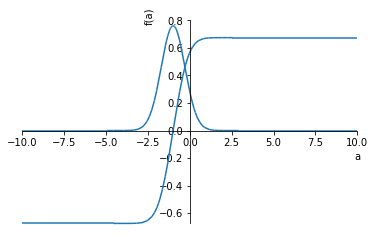

In [77]:
sympy.plot(F.subs({b:1,c:1,d:1}), iF.subs({b:1,c:1,d:1}))

In [115]:
xtrain = (np.random.random((100000,4)) - 0.5) * 20
xtest = (np.random.random((10000,4)) - 0.5) * 20
xtest[:,1:] = np.round(xtest[:,1:]/3)*3
xtest[:,2:] = xtest[:,1:2]
ytrain, ytest = lambda_F(*np.hsplit(xtrain,4)), lambda_F(*np.hsplit(xtest,4))

In [79]:
def build_nn_pair():
    X = X_input = keras.layers.Input((4,))
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(128, activation='tanh')(X)
    for _ in range(3):
        X_skip = X
        X = keras.layers.Dense(128, activation='relu')(X)
        X = keras.layers.Dense(128)(X)
        X = keras.layers.Add()([X, X_skip])
        X = keras.layers.Activation('tanh')(X)
    X = keras.layers.Dense(1)(X)
    M_Integral = keras.Model(X_input, X)
    M_Integral.compile('nadam', 'mse', ['mae'])
    X = M_Integral(X_input)
    def compute_jacobian(x):
        return K.reshape(K.stack([
            K.gradients(x[1][:,ix], x[0])[0]
            for ix in range(1)
        ], axis=1), (-1,1,4))
    def compute_grad(x):
        j = compute_jacobian(x)
        return j[:,0,:1]
    X = keras.layers.Lambda(
        lambda x: compute_grad(x) + K.sum(x[1])*0,
        output_shape=(1,))([X_input, X])
    M_DIntegral = keras.Model(X_input, X)
    M_DIntegral.compile('nadam', 'mse', ['mae'])
    return M_Integral, M_DIntegral

In [80]:
M_Integral, M_DIntegral = build_nn_pair()
M = M_DIntegral
M.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
model_25 (Model)                (None, 1)            99857       input_13[0][0]                   
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 1)            0           input_13[0][0]                   
                                                                 model_25[1][0]                   
Total params: 99,857
Trainable params: 99,849
Non-trainable params: 8
__________________________________________________________________________________________________


In [83]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=256, epochs=200, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
])

Train on 100000 samples, validate on 10000 samples
Epoch 1/200
100000/100000 [==============================] - 4s 40us/step - loss: 0.0193 - mean_absolute_error: 0.0626 - val_loss: 0.0062 - val_mean_absolute_error: 0.0309
Epoch 2/200
100000/100000 [==============================] - 4s 40us/step - loss: 0.0182 - mean_absolute_error: 0.0601 - val_loss: 0.0034 - val_mean_absolute_error: 0.0267
Epoch 3/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0177 - mean_absolute_error: 0.0592 - val_loss: 0.0036 - val_mean_absolute_error: 0.0293
Epoch 4/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0182 - mean_absolute_error: 0.0602 - val_loss: 0.0051 - val_mean_absolute_error: 0.0306
Epoch 5/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0186 - mean_absolute_error: 0.0613 - val_loss: 0.0050 - val_mean_absolute_error: 0.0303
Epoch 6/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0183 

Epoch 45/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0145 - mean_absolute_error: 0.0532 - val_loss: 0.0024 - val_mean_absolute_error: 0.0202

Epoch 00045: ReduceLROnPlateau reducing learning rate to 2.000000165480742e-11.
Epoch 46/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0155 - mean_absolute_error: 0.0549 - val_loss: 0.0024 - val_mean_absolute_error: 0.0204
Epoch 47/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0147 - mean_absolute_error: 0.0537 - val_loss: 0.0025 - val_mean_absolute_error: 0.0206
Epoch 48/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0145 - mean_absolute_error: 0.0531 - val_loss: 0.0024 - val_mean_absolute_error: 0.0201
Epoch 49/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0138 - mean_absolute_error: 0.0519 - val_loss: 0.0024 - val_mean_absolute_error: 0.0203
Epoch 50/200
100000/100000 [==========================

100000/100000 [==============================] - 4s 37us/step - loss: 0.0142 - mean_absolute_error: 0.0529 - val_loss: 0.0026 - val_mean_absolute_error: 0.0210
Epoch 89/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0144 - mean_absolute_error: 0.0526 - val_loss: 0.0026 - val_mean_absolute_error: 0.0212
Epoch 90/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0144 - mean_absolute_error: 0.0528 - val_loss: 0.0025 - val_mean_absolute_error: 0.0207

Epoch 00090: ReduceLROnPlateau reducing learning rate to 2.000000065778016e-20.
Epoch 91/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0144 - mean_absolute_error: 0.0525 - val_loss: 0.0025 - val_mean_absolute_error: 0.0203
Epoch 92/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0137 - mean_absolute_error: 0.0520 - val_loss: 0.0027 - val_mean_absolute_error: 0.0217
Epoch 93/200
100000/100000 [==============================] - 4s 38

100000/100000 [==============================] - 4s 37us/step - loss: 0.0153 - mean_absolute_error: 0.0547 - val_loss: 0.0024 - val_mean_absolute_error: 0.0203
Epoch 132/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0150 - mean_absolute_error: 0.0537 - val_loss: 0.0026 - val_mean_absolute_error: 0.0212
Epoch 133/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0155 - mean_absolute_error: 0.0549 - val_loss: 0.0025 - val_mean_absolute_error: 0.0208
Epoch 134/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0146 - mean_absolute_error: 0.0534 - val_loss: 0.0026 - val_mean_absolute_error: 0.0211
Epoch 135/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0150 - mean_absolute_error: 0.0534 - val_loss: 0.0022 - val_mean_absolute_error: 0.0196

Epoch 00135: ReduceLROnPlateau reducing learning rate to 2.000000247083397e-29.
Epoch 136/200
100000/100000 [==============================] - 

100000/100000 [==============================] - 4s 37us/step - loss: 0.0158 - mean_absolute_error: 0.0551 - val_loss: 0.0024 - val_mean_absolute_error: 0.0203
Epoch 175/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0144 - mean_absolute_error: 0.0528 - val_loss: 0.0025 - val_mean_absolute_error: 0.0208

Epoch 00175: ReduceLROnPlateau reducing learning rate to 2.0000002512444633e-37.
Epoch 176/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0148 - mean_absolute_error: 0.0539 - val_loss: 0.0027 - val_mean_absolute_error: 0.0214
Epoch 177/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0156 - mean_absolute_error: 0.0550 - val_loss: 0.0025 - val_mean_absolute_error: 0.0206
Epoch 178/200
100000/100000 [==============================] - 4s 37us/step - loss: 0.0145 - mean_absolute_error: 0.0531 - val_loss: 0.0023 - val_mean_absolute_error: 0.0200
Epoch 179/200
100000/100000 [==============================] -

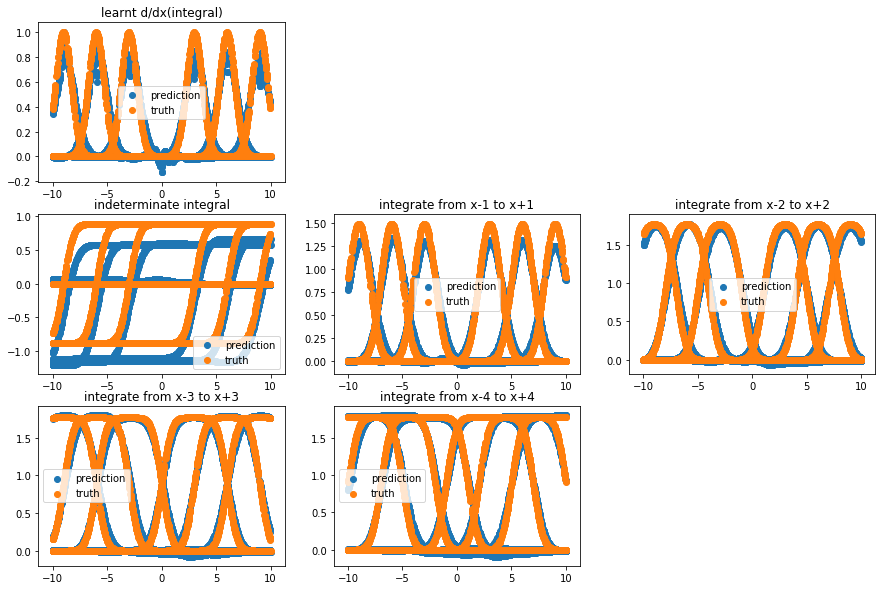

In [116]:
plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title('learnt d/dx(integral)')
plt.scatter(xtest[:,0], M_DIntegral.predict(xtest), label='prediction')
plt.scatter(xtest[:,0], lambda_F(*np.hsplit(xtest, 4)), label='truth')
plt.legend()
plt.subplot(3,3,4)
plt.title('indeterminate integral')
plt.scatter(xtest[:,0], M_Integral.predict(xtest), label='prediction')
plt.scatter(xtest[:,0], lambda_iF(*np.hsplit(xtest, 4)), label='truth')
plt.legend()
for i in range(4):
    D = i+1
    plt.subplot(3,3,i+5)
    plt.title(f'integrate from x-{D} to x+{D}')
    plt.scatter(xtest[:,0],
                M_Integral.predict(np.hstack([xtest[:,:1] + D, *np.hsplit(xtest[:,1:], 3)])) - \
                M_Integral.predict(np.hstack([xtest[:,:1] - D, *np.hsplit(xtest[:,1:], 3)])), label='prediction')
    plt.scatter(xtest[:,0],
                lambda_iF(xtest[:,:1] + D, *np.hsplit(xtest[:,1:], 3)) - \
                lambda_iF(xtest[:,:1] - D, *np.hsplit(xtest[:,1:], 3)), label='truth')
    plt.legend()
plt.show()